# Online shopping prediction

### importing libraries and read dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("data.csv")
df.head(4)

,event_time,event_type,product_id,category_id,brand,price,user_id,category_code,Unnamed: 8
0,2019-10-01 00:00:00 UTC,view,44600062,2.103810e+18,shiseido,35.79,541312140,NaN,NaN
1,2019-10-01 00:00:00 UTC,view,3900821,2.053010e+18,aqua,33.20,554748717,appliances,NaN
2,2019-10-01 00:00:01 UTC,view,17200506,2.053010e+18,NaN,543.10,519107250,furniture,NaN
3,2019-10-01 00:00:01 UTC,view,1307067,2.053010e+18,lenovo,251.74,550050854,computers,NaN


In [3]:
df = df.drop(["product_id","Unnamed: 8","user_id","category_id"],axis=1)                # droping unwanted columns

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 5 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   event_time     1048575 non-null  object 
 1   event_type     1048575 non-null  object 
 2   brand          892893 non-null   object 
 3   price          1048575 non-null  float64
 4   category_code  713814 non-null   object 
dtypes: float64(1), object(4)
memory usage: 40.0+ MB


### checking and dropping null values

In [5]:
df.dropna(subset="category_code",inplace=True)

In [6]:
df.isnull().sum()

event_time           0
event_type           0
brand            56481
price                0
category_code        0
dtype: int64

In [7]:
df.dropna(subset="brand",inplace=True)

In [8]:
df.describe()

,price
count,657333.000000
mean,362.495364
std,399.735880
min,0.880000
25%,102.730000
50%,205.660000
75%,464.010000
max,2574.070000


In [9]:
df = df[df["price"] > 10]

In [10]:
df.head()

,event_time,event_type,brand,price,category_code
1,2019-10-01 00:00:00 UTC,view,aqua,33.20,appliances
3,2019-10-01 00:00:01 UTC,view,lenovo,251.74,computers
4,2019-10-01 00:00:04 UTC,view,apple,1081.98,electronics
5,2019-10-01 00:00:05 UTC,view,pulser,908.62,computers
8,2019-10-01 00:00:10 UTC,view,baden,102.71,apparel


### convert time and date columns to integer column

In [11]:
df["hour"] = pd.to_datetime(df["event_time"]).dt.hour
df["minute"] = pd.to_datetime(df["event_time"]).dt.minute

In [12]:
df = df[df["minute"] > 0]

In [13]:
df.drop("event_time",axis=1,inplace=True)

In [14]:
df.head()

,event_type,brand,price,category_code,hour,minute
71,view,teploross,90.32,appliances,0,1
72,view,gorenje,90.07,appliances,0,1
75,view,panasonic,40.80,appliances,0,1
76,view,samsung,286.86,electronics,0,1
77,view,hp,1512.78,computers,0,1


## Take a look on data

In [15]:

# checking percentage distribution of target values


<Axes: ylabel='count'>

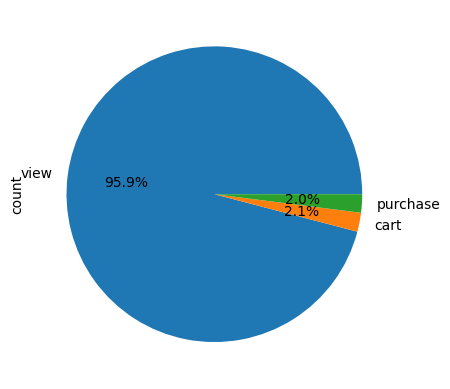

In [16]:
df.event_type.value_counts().plot(kind="pie",autopct="%1.1f%%")

In [17]:

# top buying categories


<Axes: xlabel='category_code'>

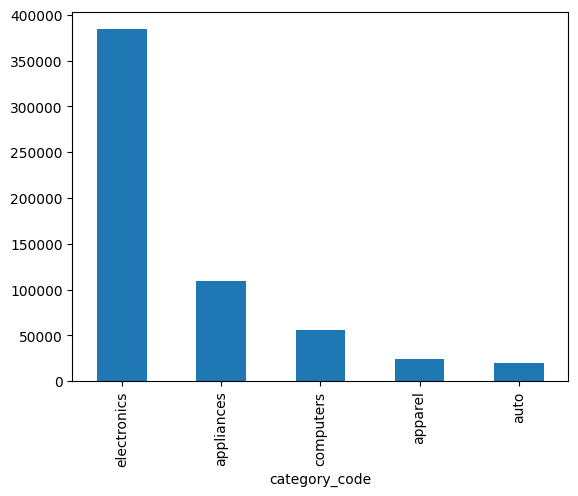

In [18]:
df.category_code.value_counts().head().plot(kind="bar")

In [19]:

# Top 10 most looked brand


<Axes: ylabel='brand'>

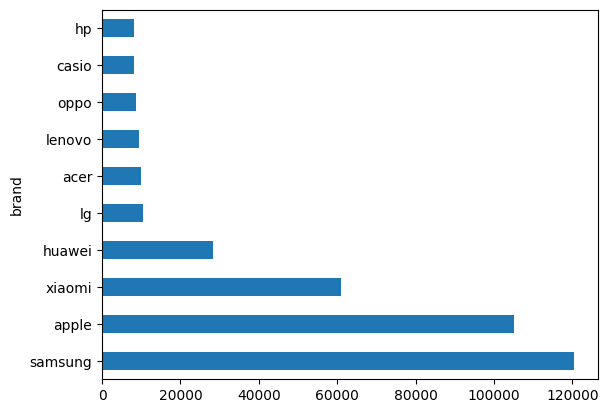

In [20]:
df.brand.value_counts().head(10).plot(kind="barh")

In [21]:

# we cant look at all brands because it gives problem when doing onehot encoding
# so we take top 100 brands


In [22]:
top_100 = df["brand"].value_counts().head(100).index
top_100

Index(['samsung', 'apple', 'xiaomi', 'huawei', 'lg', 'acer', 'lenovo', 'oppo',
       'casio', 'hp', 'bosch', 'elenberg', 'artel', 'indesit', 'respect',
       'dauscher', 'asus', 'sony', 'beko', 'nokia', 'meizu', 'pioneer', 'vivo',
       'redmond', 'philips', 'tefal', 'midea', 'starline', 'vitek', 'polaris',
       'haier', 'baden', 'janome', 'sv', 'pulser', 'oasis', 'jbl', 'scarlett',
       'brw', 'nike', 'jvc', 'ariston', 'atlant', 'electrolux', 'rieker',
       'honor', 'elari', 'oneplus', 'huter', 'karcher', 'epson', 'garmin',
       'braun', 'kenwood', 'hansa', 'wonlex', 'yasin', 'panasonic',
       'prestigio', 'alteco', 'karya', 'orient', 'bq', 'greyder', 'tissot',
       'ballu', 'kivi', 'alpine', 'bts', 'crown', 'ibox', 'kingston',
       'maxwell', 'dewalt', 'gorenje', 'msi', 'canon', 'kitfort', 'texet',
       'sho-me', 'shagovita', 'zeta', 'lorelli', 'nexpero', 'belecoo',
       'almacom', 'makita', 'gigabyte', 'dell', 'tcl', 'neoline', 'strobbs',
       'adidas', 'kicx'

In [23]:
df.shape

(639632, 6)

In [24]:
df = df[df["brand"].isin(top_100)]

### creating numeric and categorical columns


In [25]:
numeric_col = df.select_dtypes(include=("float64","int32","int64")).columns.tolist()
categorical_col = df.select_dtypes("object").columns.tolist()

In [26]:
numeric_col

['price', 'hour', 'minute']

In [27]:
categorical_col

['event_type', 'brand', 'category_code']

In [28]:
categorical_col.remove("event_type")
categorical_col

['brand', 'category_code']

In [29]:
input_df = df.drop("event_type",axis=1)
target_df = df["event_type"]

## doing one hot encoding for categorical variables

In [30]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False,handle_unknown="ignore")

In [31]:
encoder.fit(input_df[categorical_col])

OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [32]:
encoded_col = list(encoder.get_feature_names_out(categorical_col))

In [33]:
len(encoded_col)

112

In [34]:
input_df[encoded_col] = encoder.transform(input_df[categorical_col])

In [35]:
input_df.shape

(552891, 117)

### dropping categorical columns

In [36]:
input_df = input_df.drop(categorical_col,axis=1)

In [37]:
target_df.unique()

array(['view', 'purchase', 'cart'], dtype=object)

In [38]:
target_df = target_df.map({'view':0,'purchase':2,'cart':1})

## train test split

In [39]:
from sklearn.model_selection import train_test_split

In [40]:
x_train,x_test,y_train,y_test = train_test_split(input_df, target_df, test_size=0.2, random_state=42)

# Applying machine learning algorithm

In [41]:
from sklearn.linear_model import LogisticRegression

In [42]:
model = LogisticRegression(solver="liblinear")

In [43]:
model.fit(x_train,y_train)

LogisticRegression(solver='liblinear')

In [44]:
model.score(x_test,y_test)

0.953851997214661

In [45]:
model.score(x_train,y_train)

0.9542381848107219

## we got good accuracy

# Saving the model

In [46]:
online_shopping_pred ={
    "model" : model,
    "encoder" : encoder,
    "numeric_col" : numeric_col,
    "categorical_col" : categorical_col,
    "encoded_col" : encoded_col
}

In [47]:

import pickle

In [48]:
with open("online_shopping_prediction_Model","wb") as f:
    pickle.dump(online_shopping_pred,f)